<a href="https://colab.research.google.com/github/soroushmirzaei/convolutional-neural-networks-projects/blob/main/brain-tumor-mri-classification/brain-tumor-mri-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#make kaggle json file
kaggle_json = {
    "username":"kaggle-api-token-username",
    "key":"kaggle-api-token-key"
}
pd.Series(kaggle_json).to_json('kaggle.json')

#install kaggle libraries
!pip install -q kaggle

#setup kaggle libraries
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#download kaggle dataset
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset


100% 149M/149M [00:01<00:00, 96.2MB/s]
100% 149M/149M [00:01<00:00, 84.0MB/s]


In [ ]:
#unzip file
def unzip(file_name, type_file = 'zip'):
    cur_dir = os.getcwd()
    file_path = os.path.join(cur_dir, f'{file_name}.{type_file}')
    file = zipfile.ZipFile(file_path)
    file.extractall(os.path.join(cur_dir, file_name))
    file.close()


In [ ]:
unzip('brain-tumor-mri-dataset')


In [ ]:
#remove file with zero size
def remove_file_zero(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if os.path.getsize(os.path.join(root, file)) == 0:
                os.remove(os.path.join(root, file))


In [ ]:
remove_file_zero('/content/brain-tumor-mri-dataset')


In [ ]:
#romove other file type
def remove_type(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.split('.')[-1] not in ['jpg', 'jpeg', 'bmp', 'png', 'gif']:
                os.remove(os.path.join(root, file))


In [ ]:
remove_type('/content/brain-tumor-mri-dataset/Training')
remove_type('/content/brain-tumor-mri-dataset/Testing')


In [ ]:
#rename file in label num format
def rename_file(dir_path):
    for label in os.listdir(dir_path):
        num = 0
        for file in os.scandir(os.path.join(dir_path, label)):
            file_name = file.name
            ext = file_name.split('.')[1]
            num = num + 1
            os.rename(file.path, os.path.join(dir_path, label, f'{label} {num}.{ext}'))


In [ ]:
rename_file('/content/brain-tumor-mri-dataset/Training')
rename_file('/content/brain-tumor-mri-dataset/Testing')


In [ ]:
#capsfold file names
def caps_file(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for dir in dirs:
            os.rename(os.path.join(root,dir), os.path.join(root,dir.title()))
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            os.rename(os.path.join(root,file), os.path.join(root,file.title()))


In [ ]:
caps_file('/content/brain-tumor-mri-dataset/Training')
caps_file('/content/brain-tumor-mri-dataset/Testing')


In [ ]:
#define training validation set
Height = 150
Width = 150

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
train_data = train_gen.flow_from_directory('/content/brain-tumor-mri-dataset/Training',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
valid_data = valid_gen.flow_from_directory('/content/brain-tumor-mri-dataset/Testing',
                                         target_size = (Height, Width), batch_size = 32,
                                         color_mode = 'rgb', class_mode = 'sparse', seed = 0)


Found 3637 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
#define pretrained model
pretrained_model = keras.applications.InceptionV3(input_shape = (Height, Width, 3),
                                                  include_top = False)

for layer in pretrained_model.layers:
    layer.trainable = False

output_pre = pretrained_model.output


In [ ]:
#define custom pretrained model
out_layer = pretrained_model.get_layer('mixed8')
output_custom_pre = out_layer.output


In [ ]:
#create model function
def create_model(#convolution layer configuration
                 conv_layers_num, conv_filters, conv_kernel_size, flatten_dropout_ratio, 
                 #dense layer configuration
                 dense_layers_num, dense_units, dense_dropout_ratio,
                 #output layer configuration
                 out_dropout_ratio, out_units = train_data.num_classes,
                 #activations configuration
                 conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',

                 #input shape
                 inp_shape = (Height, Width, 3),

                 #compiling Configuration
                 compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                 compile_metric = ['accuracy'],
                 
                 #pretrained_model configuration
                 flatten_input = None, pretrained_input = False,
                 
                 #convolution layers
                 conv_base = True, batch_norm_conv = True,
                 #flatten layer
                 flatten_layer = True, flatten_dropout_out = True,
                 #dense layers
                 dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                 #output layer
                 batch_norm_out = True, dropout_out = True
                 ):

    #define input layer
    input = keras.Input(inp_shape)
    out = input

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Conv2D(filters = conv_filters[i],
                                      kernel_size = conv_kernel_size[i], activation = conv_activation,
                                      kernel_initializer = keras.initializers.GlorotNormal())(out)
            out = keras.layers.MaxPool2D(pool_size = 2)(out)

    #convert two dims to one dim
    if flatten_layer:
        try:
            out = keras.layers.Flatten()(flatten_input)
        except:
            out = keras.layers.Flatten()(out)

    if flatten_dropout_out:
        out = keras.layers.Dropout(flatten_dropout_ratio)(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if dropout_dense:
                out = keras.layers.Dropout(dense_dropout_ratio[i])(out)

    #define output layers
    if batch_norm_out:
        out = keras.layers.BatchNormalization()(out)
    if dropout_out:
        out = keras.layers.Dropout(out_dropout_ratio)(out)
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    if pretrained_input:
        input = pretrained_model.input

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/brain-tumor-mri-classification-model.h5')
        

In [ ]:
#create model
model = create_model(#convolution layer configuration
                     conv_layers_num = int(3), conv_filters = list([16,32,32]), conv_kernel_size = list([3,3,3]),
                     flatten_dropout_ratio = float(0.3), 
                     #dense layer configuration
                     dense_layers_num = int(2), dense_units = list([128,128]), dense_dropout_ratio = list([0.3,0.3]), 
                     #output layer configuration
                     out_dropout_ratio = float(0.3), out_units = train_data.num_classes,
                     #activations configuration
                     conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',
                     
                     #input shape
                     inp_shape = (Height, Width, 3),
                     
                     #compiling Configuration
                     compile_optimizer = 'adam', compile_loss = 'sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'],
                     
                     #pretrained_model configuration
                     flatten_input = output_custom_pre, pretrained_input = True,

                     #convolution layers
                     conv_base = True, batch_norm_conv = True,
                     #flatten layer
                     flatten_layer = True, flatten_dropout_out = True,                  
                     #dense layers
                     dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                     #output layer
                     batch_norm_out = True, dropout_out = True
                    )

In [ ]:
#print model summary
model.summary(120)


Model: "model_6"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_8 (InputLayer)                  [(None, 150, 150, 3)]      0             []                                      
                                                                                                                        
 conv2d_112 (Conv2D)                   (None, 74, 74, 32)         864           ['input_8[0][0]']                       
                                                                                                                        
 batch_normalization_130 (BatchNormali  (None, 74, 74, 32)        96            ['conv2d_112[0][0]']                    
 zation)                                                                                                                
               

In [ ]:
#fit model for training
history = model.fit(train_data, validation_data = valid_data, epochs = 100,
                    callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True,
                                                               monitor = 'val_accuracy'),
                                 keras.callbacks.CSVLogger('Log.csv'), callback(), 
                                 keras.callbacks.ReduceLROnPlateau('val_accuracy', patience = 3,
                                                                   factor = 0.1)],
                    )


Epoch 1/100
114/114 [==============================] - 259s 2s/step - loss: 0.6772 - accuracy: 0.7608 - val_loss: 0.3340 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 2/100
114/114 [==============================] - 187s 2s/step - loss: 0.3306 - accuracy: 0.8837 - val_loss: 0.2348 - val_accuracy: 0.9146 - lr: 0.0010
Epoch 3/100
114/114 [==============================] - 185s 2s/step - loss: 0.2235 - accuracy: 0.9233 - val_loss: 0.1890 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 4/100
114/114 [==============================] - 188s 2s/step - loss: 0.1638 - accuracy: 0.9412 - val_loss: 0.1596 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 5/100
114/114 [==============================] - 186s 2s/step - loss: 0.1209 - accuracy: 0.9574 - val_loss: 0.1495 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 6/100
114/114 [==============================] - 185s 2s/step - loss: 0.1059 - accuracy: 0.9656 - val_loss: 0.1566 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 7/100
114/114 [==============================] - 187

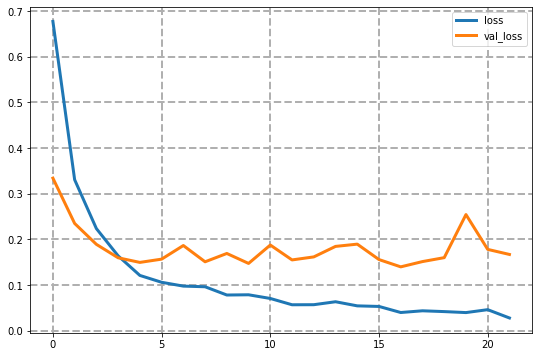

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


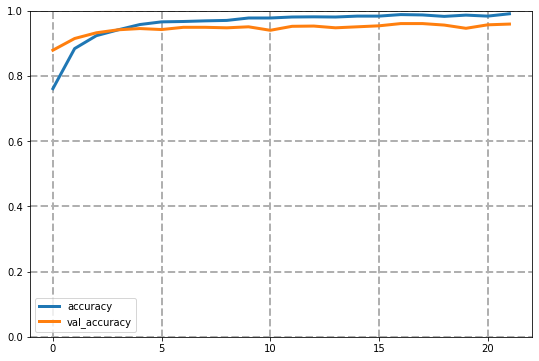

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_data, verbose = 0)
valid_set_eval = model.evaluate(valid_data, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')
print(f'Validation Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.0015	Accuracy: 100.0%
Validation Set Evaluation:
	Loss: 0.1397	Accuracy: 96.03%


In [ ]:
#make list of images for random prediction
def image_file(dir_path):
    image_list = list()
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            image_list.append(os.path.join(root, file))
    return image_list


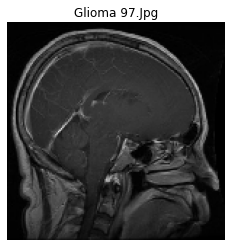

In [ ]:
#draw random image
img = np.random.choice(image_file('/content/brain-tumor-mri-dataset/Testing'))
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width),
                                         color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)

img = img/255
plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#prediction for random image
img = np.expand_dims(img, 0)
pd.DataFrame(model.predict(img), columns = train_data.class_indices)


,Glioma,Meningioma,Notumor,Pituitary
0,0.999995,4.487241e-07,7.151577e-09,0.000004


In [ ]:
#save model
model.save('/content/brain-tumor-mri-classification-model.h5')
